In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import empyrical

In [2]:
tickers = ["GE", "PFE","SBUX"]
stocks = pd.concat([yf.Ticker(i).history(period = "max")["Close"].pct_change().dropna().rename(i) for i in tickers], axis=1, join = 'inner')

In [3]:
def get_weights(r0, mean, std, covar):
   
    #mean = [i.mean() for i in stocks]
    #std = [i.std() for i in stocks]
    
    n = len(mean)
    mean = mean.values.reshape((n,1))
    #np.matmul(covar_inverse, covar)

    ones_column = np.ones((n, 1))
    mu_matrix = np.hstack((mean, ones_column))

    returns_matrix = np.vstack((r0,np.array([[1]]))) 

    A = np.zeros((2, 2))
    A[0,0] = np.matmul(np.transpose(mean), np.linalg.solve(covar.values, mean))
    A[0,1] = np.matmul(np.transpose(mean), np.linalg.solve(covar.values, ones_column))
    A[1,0] = np.matmul(np.transpose(mean), np.linalg.solve(covar.values, ones_column))
    A[1,1] = np.matmul(np.transpose(ones_column), np.linalg.solve(covar.values, ones_column))

    return np.linalg.solve(covar.values, np.matmul(mu_matrix, np.linalg.solve(A, returns_matrix)))
    

In [56]:
test 

,GE,PFE,SBUX
0,-0.014552,0.872912,0.14164


In [68]:
X = stocks.resample("7d").mean()
dates = X.index[1:-1]
portfolio = pd.DataFrame()

saved_weights = []
r0s = []

for day in dates[:-1]:
    sample = stocks[day:day+pd.offsets.DateOffset(days = 6)]
    #sample = stocks[day+pd.offsets.DateOffset(days = 7):day+pd.offsets.DateOffset(days=13)]

    mean = sample.mean(axis=0)
    r0 = mean.mean()
    r0s.append([r0])
    std = sample.std(axis=0)
    covar = sample.cov()
    weights_vector = get_weights(r0, mean, std, covar)
    portfolio = pd.concat([stocks[day+pd.offsets.DateOffset(days = 7):day+pd.offsets.DateOffset(days=13)].dot(weights_vector), portfolio])
    saved_weights.append(weights_vector.flatten())
portfolio = portfolio.sort_index()
saved_weights = pd.DataFrame(saved_weights, index = dates[:-1], columns = tickers)


E:\Python\lib\site-packages\pandas\core\frame.py:8273: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
E:\Python\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
E:\Python\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [95]:
#Troubleshooting
sample.mean(axis=0)
day = dates[1]
sample = stocks[day:day+pd.offsets.DateOffset(days = 6)]
mean = sample.mean(axis=0)
r0 = mean.mean()
r0s.append([r0])
std = sample.std(axis=0)
covar = sample.cov()
weights_vector = get_weights(r0, mean, std, covar)
weights_vector






array([[ 0.80173171],
       [-0.07557151],
       [ 0.27383979]])

In [96]:
r0

0.01191687542868971

In [97]:
mean

GE      0.002959
PFE    -0.001617
SBUX    0.034409
dtype: float64

In [98]:
covar

,GE,PFE,SBUX
GE,0.000075,0.000004,-0.000213
PFE,0.000004,0.000009,-0.000012
SBUX,-0.000213,-0.000012,0.000677


In [91]:
r0s
saved_weights

,GE,PFE,SBUX
Date,,,
1992-07-06,0.347791,0.459594,0.192616
1992-07-13,0.801732,-0.075572,0.273840
1992-07-20,0.261389,0.426276,0.312335
1992-07-27,0.964424,-0.193685,0.229261
1992-08-03,0.369565,0.594235,0.036200
...,...,...,...
2021-02-15,0.311077,0.479906,0.209016
2021-02-22,0.266616,0.334316,0.399068
2021-03-01,0.523600,-0.059348,0.535748


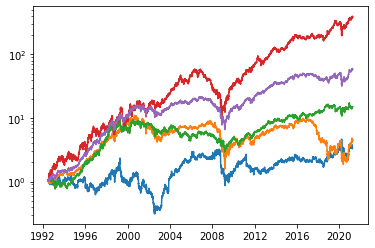

In [22]:

plt.plot((1+portfolio).cumprod())
plt.plot((1+stocks).cumprod())
plt.plot((1+equal_weights).cumprod())
plt.yscale("log")


In [23]:
empyrical.sharpe_ratio(stocks)

array([0.32293086, 0.48673031, 0.73268804])

In [19]:
equal_weights = stocks.dot(np.ones(len(tickers))/(len(tickers)))
empyrical.sharpe_ratio(equal_weights)

0.7155448204172784

In [24]:
empyrical.sharpe_ratio(portfolio.sort_index())


array([0.30392026])